In [1]:
!pip install statsmodels==0.14.2


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
#Librerias
import pickle
import os
import pandas as pd
from scipy.stats import normaltest
from scipy.stats import shapiro
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from scipy.stats import norm, expon, gamma, lognorm, chi2
from scipy.stats import kstest

## Análisis exploratorio

In [3]:
#lectura y union de archivos mensuales de ordenes de venta:
def descargar_datos(archivo):
    with open(archivo, 'rb') as f:
        datos = pickle.load(f)
    return datos

archivos = ['Ventas/df_sales_BAQ_1.pkl','Ventas/df_sales_BAQ_2.pkl','Ventas/df_sales_BAQ_3.pkl',
'Ventas/df_sales_BAQ_4.pkl', 'Ventas/df_sales_BAQ_5.pkl','Ventas/df_sales_BAQ_6.pkl',
'Ventas/df_sales_BAQ_7.pkl','Ventas/df_sales_BAQ_8.pkl','Ventas/df_sales_BAQ_9.pkl',
'Ventas/df_sales_BAQ_10.pkl','Ventas/df_sales_BAQ_11.pkl','Ventas/df_sales_BAQ_12.pkl']

lista_dfs=[]
for archivo in archivos:
    lista_dfs.append(descargar_datos(archivo))
ventas_año_completo = pd.concat(lista_dfs)

In [4]:
print(ventas_año_completo.shape)

# Contar el número de registros por mes
ordenes_por_mes = ventas_año_completo.groupby('month').size().reset_index(name='conteo')

# Imprimir el resultado
print(ordenes_por_mes)

(502154, 14)
    month  conteo
0       1   40680
1       2   39292
2       3   46944
3       4   32672
4       5   40304
5       6   42228
6       7   41294
7       8   45546
8       9   43207
9      10   41839
10     11   43538
11     12   44610


In [5]:
ventas_año_completo.dtypes

nro_orden                               object
fecha                           datetime64[ns]
producto                                object
cantidad                                object
precio                                  object
descuento                               object
customer_id                             object
sku                                     object
product_id                              object
product_quantity_x_step_unit            object
product_step_unit                       object
product_unit                            object
sku_parent                              object
month                                    int64
dtype: object

In [6]:
ventas_año_completo['product_id'] = ventas_año_completo['product_id'].astype('int')
ventas_año_completo.dtypes

nro_orden                               object
fecha                           datetime64[ns]
producto                                object
cantidad                                object
precio                                  object
descuento                               object
customer_id                             object
sku                                     object
product_id                               int64
product_quantity_x_step_unit            object
product_step_unit                       object
product_unit                            object
sku_parent                              object
month                                    int64
dtype: object

In [7]:
productos = pd.read_csv('Productos_BAQ.csv', sep=";")
print(productos.shape)
productos.head()

(137, 12)


,product_id,sku,name,producto_general,category,region_code,product_category_id,mean_shelf_life,promised_lead_time,purchasing_unit,buy_unit,weight_parameter_apricot
0,1941,BAQ-FRU1-CAT1-561:754:1940:1941,Agraz Estandar - Bandeja 125g,Agraz,Frutas,BAQ,1,4,NaN,1.0,UNID,0.13
1,100,BAQ-FRU1-CAT1-2:42:99:100,Aguacate Maduro - Kg,Aguacate,Frutas,BAQ,1,1,NaN,1.0,KG,1.00
2,210155,BAQ-FRU1-CAT104107-170565:393811:393812:210155,Aguacate Para Guacamole Extra Maduro - Kg,Aguacate,Frutas,BAQ,1,1,NaN,10.0,KG,1.00
3,101,BAQ-FRU1-CAT1-2:42:99:101,Aguacate Pintón - Kg,Aguacate,Frutas,BAQ,1,2,NaN,1.0,KG,1.00
4,1597,BAQ-FRU1-CAT1-393:618:1596:1597,Arándanos Estandar - Bandeja 125g,Arandanos,Frutas,BAQ,1,3,NaN,1.0,UNID,0.13


In [8]:
productos.dtypes

product_id                    int64
sku                          object
name                         object
producto_general             object
category                     object
region_code                  object
product_category_id           int64
mean_shelf_life               int64
promised_lead_time          float64
purchasing_unit             float64
buy_unit                     object
weight_parameter_apricot    float64
dtype: object

In [9]:
# Realizar la fusión por 'producto_id'
fusion = ventas_año_completo.merge(productos, on='product_id', how='left', indicator=True)

# Filtrar las filas que solo estén en ventas_año_completo y no en productos
producto_id_no_encontrados = fusion[fusion['_merge'] == 'left_only']['product_id'].unique()

# Obtener los 'producto' correspondientes a los 'producto_id' no encontrados en productos
productos_no_encontrados = ventas_año_completo[ventas_año_completo['product_id'].isin(producto_id_no_encontrados)][['product_id','producto']].drop_duplicates()

print(productos_no_encontrados.shape)
productos_no_encontrados


(114, 2)


,product_id,producto
218,563293,Tomate Chonto Maduración Mixta Estándar (Grand...
297,861,Papa Blanca Sucia Tamaño Mixto Sucia x Bulto
503,94846,Guayaba Maduración Mixta Al por mayor
811,287277,Cebollín Sucio Estándar Al por mayor
1154,63739,Maracuyá Mixto Media Bolsa
...,...,...
29177,130,Naranja Maduración Mixta Estandar Único
9571,123692,Lechuga Batavia Estándar Kg
14662,123705,Melón Estándar Kg
2138,1844,Zanahoria Grande Kg (Tamaño 🏠)


In [10]:
!pip install openpyxl==3.1.2


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [11]:
#exportar bd resultante  
#completar manualmente con producto_general,eliminar duplicados por id_product, cargar como Productos_faltantes
productos_no_encontrados.to_excel('productos_no_encontrados.xlsx')

In [12]:
skus_faltantes = pd.read_excel('Productos_faltantes.xlsx')
print(skus_faltantes.shape)
skus_faltantes.head(5)

(101, 3)


,product_id,producto,producto_general
0,277542,Ã‘ame Grande Kg,Name
1,608238,Ã‘ame Mixto Kg,Name
2,123699,Aguacate EstÃ¡ndar Unidad,Aguacate
3,206639,Ahuyama EstÃ¡ndar Al por mayor,Ahuyama
4,1846,Ahuyama EstÃ¡ndar Kg (TamaÃ±o ðŸ ),Ahuyama


In [13]:
categorias_producto_general = productos[['producto_general','category']].drop_duplicates()
skus_faltantes_con_categoria = skus_faltantes.merge(categorias_producto_general,how='left',on='producto_general')

skus_faltantes_con_categoria = skus_faltantes_con_categoria.rename(columns={'producto':'name'})
skus_faltantes_con_categoria.head()

,product_id,name,producto_general,category
0,277542,Ã‘ame Grande Kg,Name,Tuberculos
1,608238,Ã‘ame Mixto Kg,Name,Tuberculos
2,123699,Aguacate EstÃ¡ndar Unidad,Aguacate,Frutas
3,206639,Ahuyama EstÃ¡ndar Al por mayor,Ahuyama,Verduras
4,1846,Ahuyama EstÃ¡ndar Kg (TamaÃ±o ðŸ ),Ahuyama,Verduras


In [14]:
productos_simplificado = productos[['product_id','name','producto_general','category']]
productos_final = pd.concat([skus_faltantes_con_categoria,productos_simplificado])
productos_final.shape

(238, 4)

In [15]:
productos_final.to_excel('productos_final.xlsx')

In [16]:
#union de ventas_año_completo y productos_final con llave product_id
df = ventas_año_completo.merge(productos_final,how='left',on='product_id')
df = df.rename(columns={'category':'Categoria','name':'Nombre','product_id':'producto_id'})
print(df.shape)
df.head(10)

(502154, 17)


,nro_orden,fecha,producto,cantidad,precio,descuento,customer_id,sku,producto_id,product_quantity_x_step_unit,product_step_unit,product_unit,sku_parent,month,Nombre,producto_general,Categoria
0,18120194,2023-01-03,Papa Blanca Sucia Tamaño Mixto Kg,10.0000,2750.0000,46750.0000,1f1b98af-ee04-4849-a6cf-4fecdf7dba50,BAQ-FRU1-CAT6-234:304:750:770,770,100.0000,10.00,Kilogram,No value,1,Papa Blanca Sucia Tamaño Mixto - KG,Papa,Tuberculos
1,18131510,2023-01-03,Tomate Chonto Extramaduro Mixto Kg,1.0000,4998.0000,1499.4000,8c868951-e6d6-4d63-9592-d4b08ec43f3c,BAQ-FRU1-CAT104105-73423:168376:168377:92108,92108,2.0000,2.00,Kilogram,No value,1,Tomate Chonto Extramaduro Mixto - Kg,Tomate,Verduras
2,18106188,2023-01-03,Tomate Chonto Maduración Mixta Estándar (Grand...,4.0000,5300.0000,3180.0000,81210688-af5f-4697-bb91-6e337cd21fc2,BAQ-FRU1-CAT104105-305509:1018259:1018260:563293,563293,4.0000,1.00,Kilogram,BAQ-FRU1-CAT104105-455075:1153677:1153676:630613,1,Tomate Chonto MaduraciÃ³n Mixta EstÃ¡ndar (Gra...,Tomate,Verduras
3,18138524,2023-01-03,Ajo Estandar Kg,1.0000,8000.0000,800.0000,42a9f682-041c-4309-836e-54fa5b9a833d,BAQ-FRU1-CAT2-3:43:102:103,103,1.0000,1.00,Kilogram,No value,1,Ajo Estandar - Kg,Ajo,Verduras
4,18123207,2023-01-03,Papa Blanca Sucia Tamaño Mixto Sucia x Bulto,1.0000,2670.0000,3764.7000,65b1cfe0-329f-42eb-894f-062862379eb3,BAQ-FRU1-CAT6-234:304:750:861,861,47.0000,47.00,Kilogram,BAQ-FRU1-CAT6-234:304:750:770,1,Papa Blanca Sucia TamaÃ±o Mixto Bulto (48kg),Papa,Tuberculos
5,18153093,2023-01-03,Guayaba Maduración Mixta Al por mayor,1.0000,4200.0000,4410.0000,0894c5b7-bb3f-4710-b83e-012770f5d1fc,BAQ-FRU1-CAT104107-66:175887:175888:94846,94846,7.0000,7.00,Kilogram,BAQ-FRU1-CAT1-66:87:195:196,1,Guayaba MaduraciÃ³n Mixta Al por mayor,Guayaba,Frutas
6,18128795,2023-01-03,Papa Blanca Sucia Tamaño Mixto Sucia x Bulto,1.0000,2670.0000,3764.7000,405827dd-dbc3-48bc-82bb-b1b7209603cb,BAQ-FRU1-CAT6-234:304:750:861,861,47.0000,47.00,Kilogram,BAQ-FRU1-CAT6-234:304:750:770,1,Papa Blanca Sucia TamaÃ±o Mixto Bulto (48kg),Papa,Tuberculos
7,18159026,2023-01-03,Tomate Chonto Maduración Mixta Estándar (Grand...,5.0000,5300.0000,3975.0000,e6bce06c-fbd8-41bc-bda0-54406e0d7d06,BAQ-FRU1-CAT104105-305509:1018259:1018260:563293,563293,5.0000,1.00,Kilogram,BAQ-FRU1-CAT104105-455075:1153677:1153676:630613,1,Tomate Chonto MaduraciÃ³n Mixta EstÃ¡ndar (Gra...,Tomate,Verduras
8,18129821,2023-01-03,Ahuyama Estándar Kg - 🤑 (Insuperable),3.0000,2700.0000,0.0000,a205c5c9-7125-4e7c-8f48-e238d6d3e0d0,BAQ-FRU1-CAT2-54:85:191:192,192,3.0000,1.00,Kilogram,No value,1,Ahuyama Estándar - Kg - 🤑 (Insuperable),Ahuyama,Verduras
9,18150065,2023-01-03,Repollo Blanco Pequeño Unidad,1.0000,7340.0000,0.0000,29760e90-9c2e-410b-aeb4-a1775c8dba92,BAQ-FRU1-CAT2-13451:24499:24500:16209,16209,1.0000,1.00,Unrecognized dimension,No value,1,Repollo Blanco Pequeño - Unidad,Repollo,Verduras


In [17]:
df_nulos = df[df['producto_general'].isnull()]
df_nulos.groupby('producto_id').count()

,nro_orden,fecha,producto,cantidad,precio,descuento,customer_id,sku,product_quantity_x_step_unit,product_step_unit,product_unit,sku_parent,month,Nombre,producto_general,Categoria
producto_id,,,,,,,,,,,,,,,,


In [18]:
df[df['producto_general'].isnull()].shape

(0, 17)

In [19]:
# Validar nulos por campo (columna)
nulos_por_campo = df.isnull().sum()

# Imprimir el resultado
print("Número de valores nulos por campo:")
print(nulos_por_campo)

Número de valores nulos por campo:
nro_orden                       0
fecha                           0
producto                        0
cantidad                        0
precio                          0
descuento                       0
customer_id                     0
sku                             0
producto_id                     0
product_quantity_x_step_unit    0
product_step_unit               0
product_unit                    0
sku_parent                      0
month                           0
Nombre                          0
producto_general                0
Categoria                       0
dtype: int64


In [20]:
#registros repetidos por numero de orden
df['nro_orden'].value_counts()

nro_orden
18618434    231
14483185     70
20195652     63
21813421     60
13300993     58
           ... 
12521662      1
12505985      1
12590048      1
12591530      1
18039258      1
Name: count, Length: 140989, dtype: int64

In [21]:
#hay duplicados con mismo numero de orden, fecha, cliente, cantidad, producto. La diferencia principal es el descuento

#consulta de una orden específica
print(df[df['nro_orden'] == 18618434].shape)
df[df['nro_orden'] == 18618434].head(20)

(231, 17)


,nro_orden,fecha,producto,cantidad,precio,descuento,customer_id,sku,producto_id,product_quantity_x_step_unit,product_step_unit,product_unit,sku_parent,month,Nombre,producto_general,Categoria
22128,18618434,2023-01-19,Maracuyá Mixto Desde 1Kg,0.0476,5040.0000,267.8500,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT1-21:54:125:126,126,0.0476,1.00,Kilogram,No value,1,Maracuyá Mixto - Desde 1Kg,Maracuya,Frutas
22129,18618434,2023-01-19,Maracuyá Mixto Desde 1Kg,0.0476,5040.0000,330.6700,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT1-21:54:125:126,126,0.0476,1.00,Kilogram,No value,1,Maracuyá Mixto - Desde 1Kg,Maracuya,Frutas
22130,18618434,2023-01-19,Repollo Morado Pequeño Unidad,0.0476,5460.0000,546.0000,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT2-13447:24531:24532:16342,16342,0.0476,1.00,Unrecognized dimension,No value,1,Repollo Morado Pequeño - Unidad,Repollo,Verduras
22131,18618434,2023-01-19,Repollo Morado Pequeño Unidad,0.0476,5460.0000,73.7600,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT2-13447:24531:24532:16342,16342,0.0476,1.00,Unrecognized dimension,No value,1,Repollo Morado Pequeño - Unidad,Repollo,Verduras
22132,18618434,2023-01-19,Zanahoria Mixta Kg,0.0476,3600.0000,60.0400,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT104105-44:643471:643472:327559,327559,0.0476,1.00,Kilogram,No value,1,Zanahoria Mixta - Kg,Zanahoria,Verduras
22133,18618434,2023-01-19,Repollo Morado Pequeño Unidad,0.0476,5460.0000,101.1700,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT2-13447:24531:24532:16342,16342,0.0476,1.00,Unrecognized dimension,No value,1,Repollo Morado Pequeño - Unidad,Repollo,Verduras
22134,18618434,2023-01-19,Berenjena Estandar Único,0.0476,3800.0000,138.5100,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT2-5:77:175:176,176,0.0238,0.50,Kilogram,No value,1,Berenjena Estandar - Único,Berenjena,Verduras
22135,18618434,2023-01-19,Papaya Maradol Corriente (Mediana) Kg,0.1428,2300.0000,366.6870,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT104107-30:244845:244846:134243,134243,0.1285,0.90,Kilogram,No value,1,Papaya Maradol Corriente (Mediana) - Kg,Papaya,Frutas
22136,18618434,2023-01-19,Berenjena Estandar Único,0.0476,3800.0000,81.7900,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT2-5:77:175:176,176,0.0238,0.50,Kilogram,No value,1,Berenjena Estandar - Único,Berenjena,Verduras
22137,18618434,2023-01-19,Berenjena Estandar Único,0.0476,3800.0000,53.6600,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT2-5:77:175:176,176,0.0238,0.50,Kilogram,No value,1,Berenjena Estandar - Único,Berenjena,Verduras


In [22]:
# Crear una nueva columna 'fecha_str' con el formato 'dd-mm-yyyy'
df['fecha_str'] = df['fecha'].dt.strftime('%d-%m-%Y')

# Imprimir el DataFrame con la fecha formateada
df.head(10)

,nro_orden,fecha,producto,cantidad,precio,descuento,customer_id,sku,producto_id,product_quantity_x_step_unit,product_step_unit,product_unit,sku_parent,month,Nombre,producto_general,Categoria,fecha_str
0,18120194,2023-01-03,Papa Blanca Sucia Tamaño Mixto Kg,10.0000,2750.0000,46750.0000,1f1b98af-ee04-4849-a6cf-4fecdf7dba50,BAQ-FRU1-CAT6-234:304:750:770,770,100.0000,10.00,Kilogram,No value,1,Papa Blanca Sucia Tamaño Mixto - KG,Papa,Tuberculos,03-01-2023
1,18131510,2023-01-03,Tomate Chonto Extramaduro Mixto Kg,1.0000,4998.0000,1499.4000,8c868951-e6d6-4d63-9592-d4b08ec43f3c,BAQ-FRU1-CAT104105-73423:168376:168377:92108,92108,2.0000,2.00,Kilogram,No value,1,Tomate Chonto Extramaduro Mixto - Kg,Tomate,Verduras,03-01-2023
2,18106188,2023-01-03,Tomate Chonto Maduración Mixta Estándar (Grand...,4.0000,5300.0000,3180.0000,81210688-af5f-4697-bb91-6e337cd21fc2,BAQ-FRU1-CAT104105-305509:1018259:1018260:563293,563293,4.0000,1.00,Kilogram,BAQ-FRU1-CAT104105-455075:1153677:1153676:630613,1,Tomate Chonto MaduraciÃ³n Mixta EstÃ¡ndar (Gra...,Tomate,Verduras,03-01-2023
3,18138524,2023-01-03,Ajo Estandar Kg,1.0000,8000.0000,800.0000,42a9f682-041c-4309-836e-54fa5b9a833d,BAQ-FRU1-CAT2-3:43:102:103,103,1.0000,1.00,Kilogram,No value,1,Ajo Estandar - Kg,Ajo,Verduras,03-01-2023
4,18123207,2023-01-03,Papa Blanca Sucia Tamaño Mixto Sucia x Bulto,1.0000,2670.0000,3764.7000,65b1cfe0-329f-42eb-894f-062862379eb3,BAQ-FRU1-CAT6-234:304:750:861,861,47.0000,47.00,Kilogram,BAQ-FRU1-CAT6-234:304:750:770,1,Papa Blanca Sucia TamaÃ±o Mixto Bulto (48kg),Papa,Tuberculos,03-01-2023
5,18153093,2023-01-03,Guayaba Maduración Mixta Al por mayor,1.0000,4200.0000,4410.0000,0894c5b7-bb3f-4710-b83e-012770f5d1fc,BAQ-FRU1-CAT104107-66:175887:175888:94846,94846,7.0000,7.00,Kilogram,BAQ-FRU1-CAT1-66:87:195:196,1,Guayaba MaduraciÃ³n Mixta Al por mayor,Guayaba,Frutas,03-01-2023
6,18128795,2023-01-03,Papa Blanca Sucia Tamaño Mixto Sucia x Bulto,1.0000,2670.0000,3764.7000,405827dd-dbc3-48bc-82bb-b1b7209603cb,BAQ-FRU1-CAT6-234:304:750:861,861,47.0000,47.00,Kilogram,BAQ-FRU1-CAT6-234:304:750:770,1,Papa Blanca Sucia TamaÃ±o Mixto Bulto (48kg),Papa,Tuberculos,03-01-2023
7,18159026,2023-01-03,Tomate Chonto Maduración Mixta Estándar (Grand...,5.0000,5300.0000,3975.0000,e6bce06c-fbd8-41bc-bda0-54406e0d7d06,BAQ-FRU1-CAT104105-305509:1018259:1018260:563293,563293,5.0000,1.00,Kilogram,BAQ-FRU1-CAT104105-455075:1153677:1153676:630613,1,Tomate Chonto MaduraciÃ³n Mixta EstÃ¡ndar (Gra...,Tomate,Verduras,03-01-2023
8,18129821,2023-01-03,Ahuyama Estándar Kg - 🤑 (Insuperable),3.0000,2700.0000,0.0000,a205c5c9-7125-4e7c-8f48-e238d6d3e0d0,BAQ-FRU1-CAT2-54:85:191:192,192,3.0000,1.00,Kilogram,No value,1,Ahuyama Estándar - Kg - 🤑 (Insuperable),Ahuyama,Verduras,03-01-2023
9,18150065,2023-01-03,Repollo Blanco Pequeño Unidad,1.0000,7340.0000,0.0000,29760e90-9c2e-410b-aeb4-a1775c8dba92,BAQ-FRU1-CAT2-13451:24499:24500:16209,16209,1.0000,1.00,Unrecognized dimension,No value,1,Repollo Blanco Pequeño - Unidad,Repollo,Verduras,03-01-2023


In [23]:
# Contar el número de filas únicas teniendo en cuenta las columnas especificadas
filas_unicas = df.drop_duplicates(subset=['nro_orden', 'fecha', 'cantidad', 'customer_id', 'producto_id']).shape[0]

# Imprimir el resultado
print("Número de filas únicas:", filas_unicas)

Número de filas únicas: 501636


In [24]:
# Dejar solo las filas únicas considerando las columnas específicas
df = df.drop_duplicates(subset=['nro_orden', 'fecha', 'cantidad', 'customer_id', 'producto_id'])
df.shape

(501636, 18)

In [25]:
#registros repetidos por numero de orden
df['nro_orden'].value_counts()

nro_orden
14483185    70
20195652    62
21813421    60
13300993    58
15576573    51
            ..
12546744     1
12544400     1
12571585     1
12514025     1
18039258     1
Name: count, Length: 140989, dtype: int64

In [26]:
#consulta de una orden específica
print("La orden consultada registra: ", df['nro_orden'].value_counts().get(18618434, 0), "veces")
df[df['nro_orden'] == 18618434]

#la orden 18618434 pasó de 231 a 11 registros.

La orden consultada registra:  11 veces


,nro_orden,fecha,producto,cantidad,precio,descuento,customer_id,sku,producto_id,product_quantity_x_step_unit,product_step_unit,product_unit,sku_parent,month,Nombre,producto_general,Categoria,fecha_str
22128,18618434,2023-01-19,Maracuyá Mixto Desde 1Kg,0.0476,5040.0000,267.8500,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT1-21:54:125:126,126,0.0476,1.00,Kilogram,No value,1,Maracuyá Mixto - Desde 1Kg,Maracuya,Frutas,19-01-2023
22130,18618434,2023-01-19,Repollo Morado Pequeño Unidad,0.0476,5460.0000,546.0000,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT2-13447:24531:24532:16342,16342,0.0476,1.00,Unrecognized dimension,No value,1,Repollo Morado Pequeño - Unidad,Repollo,Verduras,19-01-2023
22132,18618434,2023-01-19,Zanahoria Mixta Kg,0.0476,3600.0000,60.0400,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT104105-44:643471:643472:327559,327559,0.0476,1.00,Kilogram,No value,1,Zanahoria Mixta - Kg,Zanahoria,Verduras,19-01-2023
22134,18618434,2023-01-19,Berenjena Estandar Único,0.0476,3800.0000,138.5100,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT2-5:77:175:176,176,0.0238,0.50,Kilogram,No value,1,Berenjena Estandar - Único,Berenjena,Verduras,19-01-2023
22135,18618434,2023-01-19,Papaya Maradol Corriente (Mediana) Kg,0.1428,2300.0000,366.6870,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT104107-30:244845:244846:134243,134243,0.1285,0.90,Kilogram,No value,1,Papaya Maradol Corriente (Mediana) - Kg,Papaya,Frutas,19-01-2023
22139,18618434,2023-01-19,Cebolla Cabezona Blanca Sin Pelar Mixta Desde 1Kg,0.0476,4841.0000,392.1200,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT104105-60271:510131:510132:258690,258690,0.0476,1.00,Kilogram,No value,1,Cebolla Cabezona Blanca Sin Pelar Mixta - Desd...,Cebolla,Verduras,19-01-2023
22150,18618434,2023-01-19,Mora Estándar Kg,0.0952,5520.0000,293.3600,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT1-59:90:201:202,202,0.0476,0.50,Kilogram,No value,1,Mora Estándar - Kg,Mora,Frutas,19-01-2023
22180,18618434,2023-01-19,Papa Blanca Sucia Tamaño Mixto KG,0.0476,2637.0000,2637.0000,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT6-234:304:750:770,770,0.4761,10.00,Kilogram,No value,1,Papa Blanca Sucia Tamaño Mixto - KG,Papa,Tuberculos,19-01-2023
22183,18618434,2023-01-19,Lulo Estándar Kg - 🤑 (Insuperable),0.0952,6732.0000,90.9400,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT1-16:51:119:120,120,0.0476,0.50,Kilogram,BAQ-FRU1-CAT104107-456426:1155955:1155956:631850,1,Lulo EstÃ¡ndar Kg - ðŸ¤‘ (Insuperable),Lulo,Frutas,19-01-2023
22185,18618434,2023-01-19,Tomate de Árbol Estándar Desde 1Kg,0.0476,3200.0000,90.3800,561ad9c8-d880-46ea-855e-422368f0f9da,BAQ-FRU1-CAT1-157:273:651:652,652,0.0476,1.00,Kilogram,No value,1,Tomate de Árbol Maduración Mixta Estándar - De...,Tomate,Verduras,19-01-2023


In [27]:
#consulta de una orden específica, la de mayor repeticón luego de eliminar duplicados por descuentos
print("La orden consultada registra: ", df['nro_orden'].value_counts().get(14483185, 0), "veces")
df[df['nro_orden'] == 14483185]

La orden consultada registra:  70 veces


,nro_orden,fecha,producto,cantidad,precio,descuento,customer_id,sku,producto_id,product_quantity_x_step_unit,product_step_unit,product_unit,sku_parent,month,Nombre,producto_general,Categoria,fecha_str
338010,14483185,2022-09-07,Zanahoria Mixta Kg,10.0000,2877.0000,863.1000,7646a8d9-2f8f-4c4b-8e57-d733d83d1308,BAQ-FRU1-CAT104105-44:643471:643472:327559,327559,10.0000,1.00,Kilogram,No value,9,Zanahoria Mixta - Kg,Zanahoria,Verduras,07-09-2022
338027,14483185,2022-09-07,Zucchini Amarillo Estándar Único,3.0000,7760.0000,0.0000,7646a8d9-2f8f-4c4b-8e57-d733d83d1308,BAQ-FRU1-CAT104105-52857:101263:101262:63782,63782,3.0000,1.00,Kilogram,No value,9,Zucchini Amarillo Estándar - Único,Zucchini,Verduras,07-09-2022
338029,14483185,2022-09-07,Champiñones Estandar Bandeja 1kg,1.0000,24000.0000,0.0000,7646a8d9-2f8f-4c4b-8e57-d733d83d1308,BAQ-FRU1-CAT5-464:619:1598:1599,1599,1.0000,1.00,Unrecognized dimension,No value,9,Champiñones Estandar - Bandeja 1kg,Champinones,Verduras,07-09-2022
338031,14483185,2022-09-07,Papa Criolla Estandar Kg - 🤑 (Insuperable),1.0000,4406.0000,0.0000,7646a8d9-2f8f-4c4b-8e57-d733d83d1308,BAQ-FRU1-CAT6-26:59:135:136,136,2.0000,2.00,Kilogram,BAQ-FRU1-CAT104111-455604:1155694:1155695:631134,9,Papa Criolla Estandar Kg - ðŸ¤‘ (Insuperable),Papa,Tuberculos,07-09-2022
338035,14483185,2022-09-07,Ají Topito Estándar Kg,4.0000,3600.0000,0.0000,7646a8d9-2f8f-4c4b-8e57-d733d83d1308,BAQ-FRU1-CAT1-61:92:205:229,229,2.0000,0.50,Kilogram,No value,9,Ají Topito Estándar - Kg,Aji,Verduras,07-09-2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338512,14483185,2022-09-07,Plátano Hartón Verde Pequeño Maduro,5.0000,3470.0000,0.0000,7646a8d9-2f8f-4c4b-8e57-d733d83d1308,BAQ-FRU1-CAT1-47:68:804:805,805,6.0000,1.20,Kilogram,No value,9,Plátano Hartón Verde Pequeño - Maduro,Platano,Verduras,07-09-2022
338513,14483185,2022-09-07,Manzana Roja Estandar 1/4 Caja,1.0000,16820.0000,0.0000,7646a8d9-2f8f-4c4b-8e57-d733d83d1308,BAQ-FRU1-CAT104107-186:99814:99813:62927,62927,4.5000,4.50,Kilogram,BAQ-FRU1-CAT1-186:445:1139:1192,9,Manzana Roja Estandar 1/4 Caja,Manzana,Frutas,07-09-2022
338516,14483185,2022-09-07,Ñame Estándar Kg,10.0000,3140.0000,0.0000,7646a8d9-2f8f-4c4b-8e57-d733d83d1308,BAQ-FRU1-CAT6-64:86:193:194,194,5.0000,0.50,Kilogram,No value,9,Ñame Estándar - Kg,Name,Tuberculos,07-09-2022
338528,14483185,2022-09-07,Ahuyama Estándar Kg - 🤑 (Insuperable),3.0000,2550.0000,0.0000,7646a8d9-2f8f-4c4b-8e57-d733d83d1308,BAQ-FRU1-CAT2-54:85:191:192,192,3.0000,1.00,Kilogram,No value,9,Ahuyama Estándar - Kg - 🤑 (Insuperable),Ahuyama,Verduras,07-09-2022


In [28]:
print(df.shape)
df.columns

(501636, 18)


Index(['nro_orden', 'fecha', 'producto', 'cantidad', 'precio', 'descuento',
       'customer_id', 'sku', 'producto_id', 'product_quantity_x_step_unit',
       'product_step_unit', 'product_unit', 'sku_parent', 'month', 'Nombre',
       'producto_general', 'Categoria', 'fecha_str'],
      dtype='object')

In [29]:
# Calcular la cantidad de números de orden distintos en todo el DataFrame
cantidad_nro_orden_distintos = df['nro_orden'].nunique()

print("Cantidad de números de orden distintos en todo el DataFrame:", cantidad_nro_orden_distintos)

Cantidad de números de orden distintos en todo el DataFrame: 140989


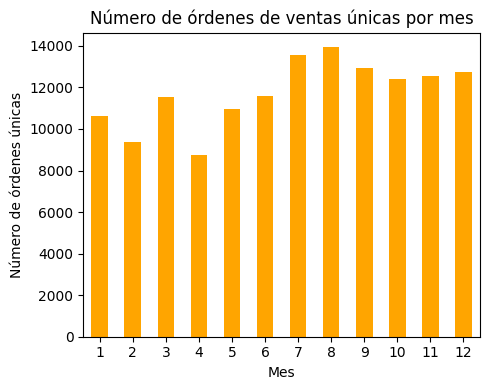

In [30]:
# Contar el número de órdenes únicas por mes
ordenes_por_mes = df.groupby('month')['nro_orden'].nunique()

# Graficar el número de órdenes únicas por mes
plt.figure(figsize=(5, 4))
ordenes_por_mes.plot(kind='bar', color='orange')
plt.title('Número de órdenes de ventas únicas por mes')
plt.xlabel('Mes')
plt.ylabel('Número de órdenes únicas')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [31]:
ordenes_por_mes

month
1     10604
2      9384
3     11558
4      8769
5     10976
6     11577
7     13553
8     13932
9     12915
10    12421
11    12569
12    12731
Name: nro_orden, dtype: int64

In [32]:
# Encontrar la fecha máxima y mínima de tus ventas
fecha_maxima = df['fecha'].max()
fecha_minima = df['fecha'].min()

print("Fecha mínima de ventas:", fecha_minima)
print("Fecha máxima de ventas:", fecha_maxima)

Fecha mínima de ventas: 2022-07-01 00:00:00
Fecha máxima de ventas: 2023-07-01 00:00:00


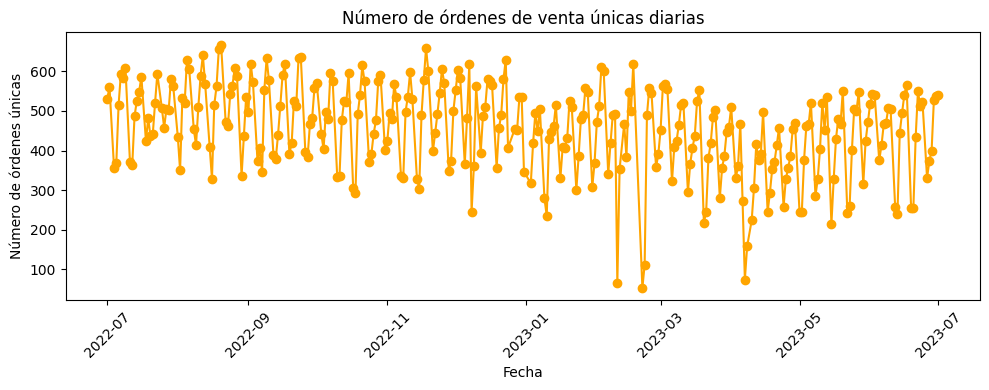

In [33]:
# Contar el número de órdenes únicas por día
ordenes_diarias_unicas = df.drop_duplicates(subset='nro_orden').groupby(df['fecha'].dt.date).size()

# Graficar el número de órdenes únicas por día
plt.figure(figsize=(10, 4))
ordenes_diarias_unicas.plot(kind='line', marker='o', color='orange')
plt.title('Número de órdenes de venta únicas diarias')
plt.xlabel('Fecha')
plt.ylabel('Número de órdenes únicas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Encontrar los top 5 de los días con el mayor número de órdenes de venta únicas
top_5_mayor = ordenes_diarias_unicas.nlargest(5)

# Encontrar los top 5 de los días con el menor número de órdenes de venta únicas
top_5_menor = ordenes_diarias_unicas.nsmallest(5)

print("Top 5 de días con el mayor número de órdenes de venta únicas:")
print(top_5_mayor)

print("\nTop 5 de días con el menor número de órdenes de venta únicas:")
print(top_5_menor)

Top 5 de días con el mayor número de órdenes de venta únicas:
fecha
2022-08-20    668
2022-11-18    659
2022-08-19    656
2022-08-12    641
2022-09-24    637
dtype: int64

Top 5 de días con el menor número de órdenes de venta únicas:
fecha
2023-02-21     53
2023-02-10     66
2023-04-07     74
2023-02-22    112
2023-04-08    158
dtype: int64


In [35]:
# Contar el número de órdenes únicas por día de la semana
ordenes_unicas_por_dia_semana = df.drop_duplicates(subset='nro_orden').groupby(df['fecha'].dt.dayofweek).size()

print("Número de órdenes de venta únicas por día de la semana:")
ordenes_unicas_por_dia_semana

Número de órdenes de venta únicas por día de la semana:


fecha
0    16773
1    18923
2    23633
3    25637
4    28033
5    27990
dtype: int64

In [36]:
#No hay ordenes registradas los domingos
# Renombrar los días de la semana
ordenes_unicas_por_dia_semana.index = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado']

# Calcular el porcentaje por día de la semana
porcentaje_por_dia_semana = ((ordenes_unicas_por_dia_semana / ordenes_unicas_por_dia_semana.sum()) * 100).round(1)

# Crear un DataFrame con los datos
tabla_ordenes_por_dia_semana = pd.DataFrame({'Número de órdenes únicas': ordenes_unicas_por_dia_semana,
                                              'Porcentaje': porcentaje_por_dia_semana})

tabla_ordenes_por_dia_semana

,Número de órdenes únicas,Porcentaje
Lunes,16773,11.9
Martes,18923,13.4
Miércoles,23633,16.8
Jueves,25637,18.2
Viernes,28033,19.9
Sábado,27990,19.9


In [37]:
# Calcular el número de registros por orden de venta
registros_por_orden = df.groupby('nro_orden').size().sort_values(ascending=False)
registros_por_orden

nro_orden
14483185    70
20195652    62
21813421    60
13300993    58
15576573    51
            ..
15325391     1
15325231     1
15325111     1
19237185     1
11954510     1
Length: 140989, dtype: int64

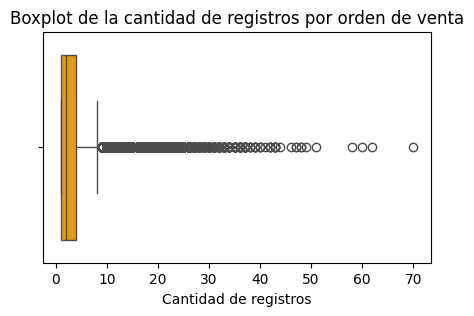

In [38]:
# Crear el boxplot
plt.figure(figsize=(5, 3))  # Establecer el tamaño de la figura
sns.boxplot(x=registros_por_orden, color='orange')

# Añadir etiquetas y título
plt.xlabel('Cantidad de registros')
plt.title('Boxplot de la cantidad de registros por orden de venta')

# Mostrar el gráfico
plt.show()

In [39]:
# Calcular el número promedio de registros por orden de venta
promedio_registros_por_orden = df.groupby('nro_orden').size().mean()

print("Número promedio de registros por orden de venta:", promedio_registros_por_orden.round(1))

# Encontrar la orden de venta que tiene más registros
orden_con_mas_registros = df.groupby('nro_orden').size().idxmax()
cantidad_mas_registros = df.groupby('nro_orden').size().max()

print("Orden de venta con más registros:", orden_con_mas_registros)
print("Cantidad de registros para esta orden de venta:", cantidad_mas_registros)

Número promedio de registros por orden de venta: 3.6
Orden de venta con más registros: 14483185
Cantidad de registros para esta orden de venta: 70


In [40]:
# Calcular el número de registros de órdenes de venta únicos por cliente
registros_por_cliente = (df.drop_duplicates(subset='nro_orden').groupby('customer_id').size().sort_values(ascending=False))

registros_por_cliente

customer_id
c1f7d038-3744-4dae-b2df-486895bb6837    568
b3795e9d-4775-4452-98f4-8be08474ceb1    361
2e1565b3-120a-49b5-ad4d-e18d0f8ed68b    331
807837bb-b93b-4f06-b442-0f5f7ae577a5    282
55940636-955c-40db-8c28-83f8dd0e18c7    273
                                       ... 
d7c83af9-8f21-4997-bf95-3dce47fc86f7      1
482180e4-592f-48f7-a4e6-e732656c5427      1
a09b5feb-e610-4c85-ba6d-35b9a2f0f4f0      1
d7d64768-83f2-40ee-82d0-56d0dc80a49e      1
6dc84f78-e9b0-429c-ab12-2030f02f07b3      1
Length: 11759, dtype: int64

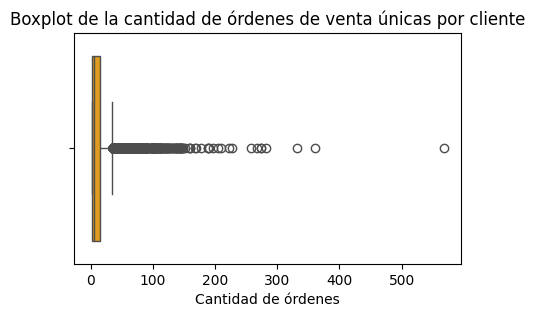

In [41]:
# Crear el boxplot
plt.figure(figsize=(5, 3))  # Establecer el tamaño de la figura
sns.boxplot(x=registros_por_cliente, color='orange')

# Añadir etiquetas y título
plt.xlabel('Cantidad de órdenes')
plt.title('Boxplot de la cantidad de órdenes de venta únicas por cliente')

# Mostrar el gráfico
plt.show()

In [42]:
# Calcular el número promedio de registros de órdenes de venta únicos por cliente
promedio_registros_por_cliente = (df.drop_duplicates(subset='nro_orden').groupby('customer_id').size().mean()).round(1)

print("Número promedio de registros de órdenes de venta únicos por cliente:", promedio_registros_por_cliente)

# Contar cuántos clientes distintos registran al menos una orden de venta
clientes_con_ordenes = df['customer_id'].nunique()

print("Número de clientes distintos que registran al menos una orden de venta:", clientes_con_ordenes)

# Encontrar al cliente con el mayor número de órdenes de ventas únicas según nro_orden
cliente_con_mas_ordenes = df.drop_duplicates(subset='nro_orden').groupby('customer_id').size().idxmax()
cantidad_mas_ordenes = df.drop_duplicates(subset='nro_orden').groupby('customer_id').size().max()

print("Cliente con el mayor número de órdenes de venta únicas según nro_orden:", cliente_con_mas_ordenes)
print("Cantidad de órdenes de venta únicas para este cliente:", cantidad_mas_ordenes)


Número promedio de registros de órdenes de venta únicos por cliente: 12.0
Número de clientes distintos que registran al menos una orden de venta: 11759
Cliente con el mayor número de órdenes de venta únicas según nro_orden: c1f7d038-3744-4dae-b2df-486895bb6837
Cantidad de órdenes de venta únicas para este cliente: 568


In [43]:
# Contar cuántos producto_general distintos tienen al menos una venta registrada
productos_con_ventas = df.drop_duplicates(subset='nro_orden')['producto_general'].nunique()

print("Número de producto_general distintos con al menos una venta registrada:", productos_con_ventas)


# Contar cuántos códigos de productos distintos tienen al menos una venta registrada
id_productos_con_ventas = df.drop_duplicates(subset='nro_orden')['producto_id'].nunique()

print("Número de producto_id distintos con al menos una venta registrada:", id_productos_con_ventas)

Número de producto_general distintos con al menos una venta registrada: 71
Número de producto_id distintos con al menos una venta registrada: 232


In [44]:
# Calcular el número de ventas únicas por producto_general
ventas_unicas_por_producto_general = df.drop_duplicates(subset=['nro_orden', 'producto_general']).groupby('producto_general').size()

# Calcular los top 10 de productos generales con más ventas únicas
top_10_mas_ventas_unicas = ventas_unicas_por_producto_general.nlargest(10)
print("top 10 productos generales con mayor número de ordenes de venta únicas: ",top_10_mas_ventas_unicas)

# Calcular los top 10 de productos con menos ventas únicas
top_10_menos_ventas_unicas = ventas_unicas_por_producto_general.nsmallest(10)
print("top 10 productos generales con menor número de ordenes de venta únicas: ",top_10_menos_ventas_unicas)

top 10 productos generales con mayor número de ordenes de venta únicas:  producto_general
Cebolla      65189
Papa         52973
Tomate       45348
Ajo          25956
Pimenton     25936
Zanahoria    20826
Apio         17039
Lechuga      13350
Yuca         12155
Limon        10791
dtype: int64
top 10 productos generales con menor número de ordenes de venta únicas:  producto_general
Cogollo        117
Bijao          124
Limonaria      136
Col            142
Arveja         149
Ciruela        168
Guasca         235
Tomillo        266
Champinones    283
Nispero        300
dtype: int64


Text(0.5, 1.0, 'Top 10 de productos con menos ventas únicas')

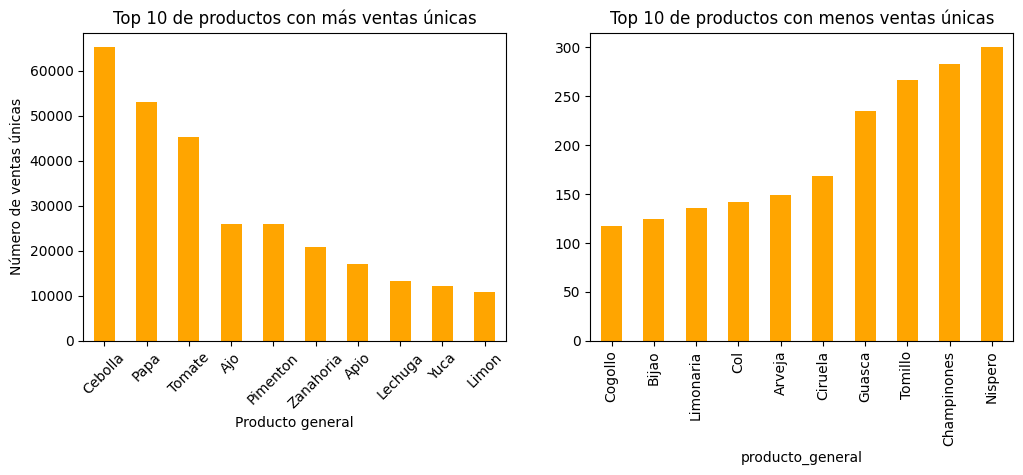

In [45]:
# Crear las visualizaciones
plt.figure(figsize=(12, 4))

# Gráfico para el top de productos con más ventas únicas
plt.subplot(1, 2, 1)
top_10_mas_ventas_unicas.plot(kind='bar', color='orange')
plt.title('Top 10 de productos con más ventas únicas')
plt.xlabel('Producto general')
plt.ylabel('Número de ventas únicas')
plt.xticks(rotation=45)

# Gráfico para el top de productos con menos ventas únicas
plt.subplot(1, 2, 2)
top_10_menos_ventas_unicas.plot(kind='bar', color='orange')
plt.title('Top 10 de productos con menos ventas únicas')


In [46]:
# Filtrar el DataFrame por el producto_general especifico
ventas_especifico = df[df['producto_general'] == 'Cebolla']

# Contar el número de ventas únicas por "Nombre" y "producto_id"
ventas_unicas_por_producto = ventas_especifico.groupby(['producto_id', 'Nombre']).nro_orden.nunique().reset_index(name='ventas_unicas')

# Ordenar el DataFrame por el número de ventas únicas
ventas_unicas_por_producto = ventas_unicas_por_producto.sort_values(by='ventas_unicas', ascending=False)

# Convertir el DataFrame a una cadena y luego imprimirlo
print(ventas_unicas_por_producto.to_string(index=False))

 producto_id                                                          Nombre  ventas_unicas
      258690             Cebolla Cabezona Blanca Sin Pelar Mixta - Desde 1Kg          25748
       26107                             Cebolla Larga Junca  Atado - Unidad          17494
      258696            Cebolla Cabezona Blanca Sin Pelar Mixta Al por mayor          10634
        1848                              Cebolla Roja Mixta Mixta Desde 1Kg          10153
         171                           Cebolla Roja Mixta  Mixta - Desde 5kg           9827
       62904                           Cebolla Roja Mixta Mixta Al por mayor           5189
       73211                   Cebolla Cabezona Blanca Sin Pelar Grande - Kg           1872
         724                                  Cebolla Roja Mixta PequeÃ±a Kg           1790
         107                       Cebolla Cabezona Blanca Limpia Mixta - Kg           1722
       36878                                Cebolla Puerro Estándar - Unidad    

In [47]:
df.describe()

,fecha,producto_id,month
count,501636,501636.000000,501636.000000
mean,2022-12-28 19:16:44.569050624,83879.732583,6.615536
min,2022-07-01 00:00:00,100.000000,1.000000
25%,2022-09-29 00:00:00,652.000000,3.000000
50%,2022-12-27 00:00:00,1848.000000,7.000000
75%,2023-03-25 00:00:00,92108.000000,10.000000
max,2023-07-01 00:00:00,636057.000000,12.000000
std,NaN,149112.576958,3.462794


# Detección Anomalías

### Verificación de supuestos

<img src="Distribucion-Normal.png" width="" align="" />

1. Distribución normal de los datos: También conocida como distribución gaussiana, es una de las distribuciones más importantes en estadística y se caracteriza por su forma de campana simétrica. En una distribución normal, la media, la mediana y la moda son iguales y se encuentran en el centro de la distribución. La mayor parte de los datos (aproximadamente el 68%) se encuentran dentro de un desviación estándar de la media, y aproximadamente el 95% de los datos se encuentran dentro de dos desviaciones estándar de la media. La distribución normal está completamente definida por dos parámetros: la media (μ) y la desviación estándar (σ).

In [48]:
print(ordenes_diarias_unicas)


fecha
2022-07-01    530
2022-07-02    561
2022-07-04    356
2022-07-05    369
2022-07-06    516
             ... 
2023-06-27    373
2023-06-28    400
2023-06-29    528
2023-06-30    539
2023-07-01    540
Length: 310, dtype: int64


In [49]:

# Ajusta diferentes distribuciones a los datos
distribuciones = [norm, expon, gamma, lognorm, chi2]
params = {}
p_values = {}

for distribucion in distribuciones:
    params[distribucion] = distribucion.fit(ordenes_diarias_unicas)
    ks_statistic, p_value = kstest(ordenes_diarias_unicas, distribucion.cdf, params[distribucion])
    p_values[distribucion.name] = p_value
    print(f"{distribucion.name}: Estadístico KS={ks_statistic}, Valor p={p_value}")


# Encuentra la distribución con el valor p más alto
mejor_distribucion = max(p_values, key=p_values.get)

print(f"La distribución que mejor se ajusta es: {mejor_distribucion}, Valor p={p_values[mejor_distribucion]}")


norm: Estadístico KS=0.0714406171791897, Valor p=0.08043897332311678
expon: Estadístico KS=0.378228696901925, Valor p=2.334680177140878e-40
gamma: Estadístico KS=0.08048882312830624, Valor p=0.03404217674093479
lognorm: Estadístico KS=0.7651218273252687, Valor p=2.6575125290679956e-190
chi2: Estadístico KS=0.07667670967721035, Valor p=0.04951937302347387
La distribución que mejor se ajusta es: norm, Valor p=0.08043897332311678


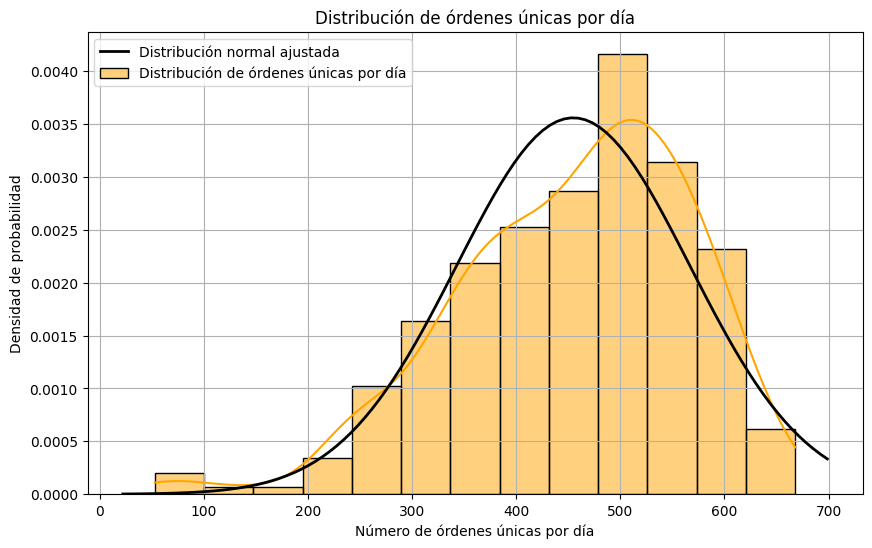

In [50]:
# Ajustar la distribución normal a los datos
mu, sigma = norm.fit(ordenes_diarias_unicas)

# Graficar la distribución de órdenes únicas por día junto con la distribución normal ajustada
plt.figure(figsize=(10, 6))

# Histograma de la distribución de órdenes únicas por día
sns.histplot(ordenes_diarias_unicas, kde=True, color='orange', stat='density', label='Distribución de órdenes únicas por día')

# Distribución normal ajustada
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2, label='Distribución normal ajustada')

plt.xlabel('Número de órdenes únicas por día')
plt.ylabel('Densidad de probabilidad')
plt.title('Distribución de órdenes únicas por día')
plt.legend()

plt.grid(True)
plt.show()


### Construcción Algoritmo

In [51]:
#generacion del df con el resumen de ventas mensuales por producto_general

# Convertir la columna 'cantidad' a tipo int
df['cantidad'] = df['cantidad'].astype(int)

# Agrupar por producto, product_unit, mes y calcular el conteo de registros y la suma de la cantidad
ventas_generales_mes = df.groupby(['producto_general', 'month']).agg({'nro_orden': 'count', 'cantidad': 'sum'}).reset_index()

# Renombrar las columnas
ventas_generales_mes = ventas_generales_mes.rename(columns={'nro_orden': 'conteo_registros', 'cantidad': 'suma_cantidad'})

# Mostrar el nuevo DataFrame
ventas_generales_mes.head(10)

,producto_general,month,conteo_registros,suma_cantidad
0,Acelga,1,33,72
1,Acelga,2,37,63
2,Acelga,3,29,39
3,Acelga,4,18,18
4,Acelga,5,28,28
5,Acelga,6,20,20
6,Acelga,7,88,149
7,Acelga,8,104,178
8,Acelga,9,90,150
9,Acelga,10,94,155


In [52]:
# Exportar el DataFrame ventas_generales_mes a un archivo CSV
ventas_generales_mes.to_csv('ventas_generales_mes.csv', index=False)
#os.getcwd()

In [53]:
ventas_generales_mes.columns

Index(['producto_general', 'month', 'conteo_registros', 'suma_cantidad'], dtype='object')

In [54]:
#generacion del df con los umbrales de alertamiento por producto_general

# Filtrar los meses del 6 al 11, meses que se tomaran para calcular los umbrales de alertamiento
df_meses_ref = ventas_generales_mes[(ventas_generales_mes['month'] >= 6) & (ventas_generales_mes['month'] <= 11)]

# Agrupar por producto_general, product_unit y month y calcular el promedio y la desviación estándar
df_umbrales = df_meses_ref.groupby(['producto_general']).agg({
    'conteo_registros': ['mean', 'std'],
    'suma_cantidad': ['mean', 'std']
}).reset_index()

# Renombrar las columnas
df_umbrales.columns = ['producto_general', 
                    'promedio_conteo_registros', 'desviacion_conteo_registros', 
                    'promedio_suma_cantidad', 'desviacion_suma_cantidad']

sd=2 #definir la desviación estándar a considerar

# Calcular los umbrales de alertamiento
df_umbrales['umbral_inf_conteo'] = df_umbrales['promedio_conteo_registros'] - sd * df_umbrales['desviacion_conteo_registros']
df_umbrales['umbral_sup_conteo'] = df_umbrales['promedio_conteo_registros'] + sd * df_umbrales['desviacion_conteo_registros']
df_umbrales['umbral_inf_cantidad'] = df_umbrales['promedio_suma_cantidad'] - sd * df_umbrales['desviacion_suma_cantidad']
df_umbrales['umbral_sup_cantidad'] = df_umbrales['promedio_suma_cantidad'] + sd * df_umbrales['desviacion_suma_cantidad']

# Mostrar el nuevo DataFrame
df_umbrales.head(10)

,producto_general,promedio_conteo_registros,desviacion_conteo_registros,promedio_suma_cantidad,desviacion_suma_cantidad,umbral_inf_conteo,umbral_sup_conteo,umbral_inf_cantidad,umbral_sup_cantidad
0,Acelga,75.833333,31.218050,126.666667,56.933880,13.397233,138.269434,12.798907,240.534426
1,Agraz,32.333333,9.811558,44.166667,14.077168,12.710218,51.956449,16.012330,72.321003
2,Aguacate,281.333333,89.888079,797.666667,299.321678,101.557176,461.109490,199.023312,1396.310022
3,Ahuyama,810.000000,127.400157,2424.000000,792.659069,555.199686,1064.800314,838.681862,4009.318138
4,Aji,594.333333,178.754207,1112.333333,424.295495,236.824919,951.841748,263.742344,1960.924322
5,Ajo,2098.166667,71.809238,3116.666667,501.014837,1954.548191,2241.785143,2114.636993,4118.696340
6,Albahaca,47.500000,15.719415,91.666667,23.963862,16.061171,78.938829,43.738943,139.594390
7,Apio,1566.333333,97.987074,3011.000000,198.161550,1370.359185,1762.307481,2614.676899,3407.323101
8,Arandanos,60.500000,40.193283,109.500000,109.224082,-19.886566,140.886566,-108.948163,327.948163
9,Arracacha,137.000000,47.320186,314.166667,112.765982,42.359628,231.640372,88.634703,539.698630


In [55]:
#valores ultimo mes por producto_general
df_ultimo_mes = ventas_generales_mes[(ventas_generales_mes['month'] ==12)]
print(df_ultimo_mes.shape)
df_ultimo_mes.head(5)

(70, 4)


,producto_general,month,conteo_registros,suma_cantidad
11,Acelga,12,25,52
23,Agraz,12,27,32
35,Aguacate,12,534,1687
47,Ahuyama,12,1020,2920
59,Aji,12,534,959


In [56]:
# Realizar la unión por 'producto_general'
df_alertamiento = df_umbrales.merge(df_ultimo_mes[['producto_general', 'conteo_registros', 'suma_cantidad']], on='producto_general', how='left')

# Renombrar las columnas de conteo_registros y suma_cantidad
df_alertamiento = df_alertamiento.rename(columns={'conteo_registros': 'ult_mes_conteo', 'suma_cantidad': 'ult_mes_cantidad'})

# Mostrar el nuevo DataFrame
df_alertamiento.head(10)

,producto_general,promedio_conteo_registros,desviacion_conteo_registros,promedio_suma_cantidad,desviacion_suma_cantidad,umbral_inf_conteo,umbral_sup_conteo,umbral_inf_cantidad,umbral_sup_cantidad,ult_mes_conteo,ult_mes_cantidad
0,Acelga,75.833333,31.218050,126.666667,56.933880,13.397233,138.269434,12.798907,240.534426,25.0,52.0
1,Agraz,32.333333,9.811558,44.166667,14.077168,12.710218,51.956449,16.012330,72.321003,27.0,32.0
2,Aguacate,281.333333,89.888079,797.666667,299.321678,101.557176,461.109490,199.023312,1396.310022,534.0,1687.0
3,Ahuyama,810.000000,127.400157,2424.000000,792.659069,555.199686,1064.800314,838.681862,4009.318138,1020.0,2920.0
4,Aji,594.333333,178.754207,1112.333333,424.295495,236.824919,951.841748,263.742344,1960.924322,534.0,959.0
5,Ajo,2098.166667,71.809238,3116.666667,501.014837,1954.548191,2241.785143,2114.636993,4118.696340,2716.0,4097.0
6,Albahaca,47.500000,15.719415,91.666667,23.963862,16.061171,78.938829,43.738943,139.594390,40.0,82.0
7,Apio,1566.333333,97.987074,3011.000000,198.161550,1370.359185,1762.307481,2614.676899,3407.323101,1275.0,2690.0
8,Arandanos,60.500000,40.193283,109.500000,109.224082,-19.886566,140.886566,-108.948163,327.948163,29.0,38.0
9,Arracacha,137.000000,47.320186,314.166667,112.765982,42.359628,231.640372,88.634703,539.698630,74.0,139.0


In [57]:
#calculo de flags de detección de anomalías 

# flags para numero de ventas (conteo):
df_alertamiento['anomalia_dism_conteo'] = (df_alertamiento['ult_mes_conteo'] < df_alertamiento['umbral_inf_conteo']).astype(int)
df_alertamiento['anomalia_aum_conteo'] = (df_alertamiento['ult_mes_conteo'] > df_alertamiento['umbral_sup_conteo']).astype(int)

# flags para cantidades vendidas (cantidad):
df_alertamiento['anomalia_dism_cantidad'] = (df_alertamiento['ult_mes_cantidad'] < df_alertamiento['umbral_inf_cantidad']).astype(int)
df_alertamiento['anomalia_aum_cantidad'] = (df_alertamiento['ult_mes_cantidad'] > df_alertamiento['umbral_sup_cantidad']).astype(int)


# Mostrar el nuevo DataFrame
df_alertamiento.head(10)


,producto_general,promedio_conteo_registros,desviacion_conteo_registros,promedio_suma_cantidad,desviacion_suma_cantidad,umbral_inf_conteo,umbral_sup_conteo,umbral_inf_cantidad,umbral_sup_cantidad,ult_mes_conteo,ult_mes_cantidad,anomalia_dism_conteo,anomalia_aum_conteo,anomalia_dism_cantidad,anomalia_aum_cantidad
0,Acelga,75.833333,31.218050,126.666667,56.933880,13.397233,138.269434,12.798907,240.534426,25.0,52.0,0,0,0,0
1,Agraz,32.333333,9.811558,44.166667,14.077168,12.710218,51.956449,16.012330,72.321003,27.0,32.0,0,0,0,0
2,Aguacate,281.333333,89.888079,797.666667,299.321678,101.557176,461.109490,199.023312,1396.310022,534.0,1687.0,0,1,0,1
3,Ahuyama,810.000000,127.400157,2424.000000,792.659069,555.199686,1064.800314,838.681862,4009.318138,1020.0,2920.0,0,0,0,0
4,Aji,594.333333,178.754207,1112.333333,424.295495,236.824919,951.841748,263.742344,1960.924322,534.0,959.0,0,0,0,0
5,Ajo,2098.166667,71.809238,3116.666667,501.014837,1954.548191,2241.785143,2114.636993,4118.696340,2716.0,4097.0,0,1,0,0
6,Albahaca,47.500000,15.719415,91.666667,23.963862,16.061171,78.938829,43.738943,139.594390,40.0,82.0,0,0,0,0
7,Apio,1566.333333,97.987074,3011.000000,198.161550,1370.359185,1762.307481,2614.676899,3407.323101,1275.0,2690.0,1,0,0,0
8,Arandanos,60.500000,40.193283,109.500000,109.224082,-19.886566,140.886566,-108.948163,327.948163,29.0,38.0,0,0,0,0
9,Arracacha,137.000000,47.320186,314.166667,112.765982,42.359628,231.640372,88.634703,539.698630,74.0,139.0,0,0,0,0


In [58]:
#calcular las diferencias para rankeo de alertas / anomalías:
df_alertamiento['diferencia_conteo'] = df_alertamiento['ult_mes_conteo'] - df_alertamiento['promedio_conteo_registros']
df_alertamiento['diferencia_cantidad'] = df_alertamiento['ult_mes_cantidad'] - df_alertamiento['promedio_suma_cantidad']

# Mostrar el nuevo DataFrame
df_alertamiento.head(10)


,producto_general,promedio_conteo_registros,desviacion_conteo_registros,promedio_suma_cantidad,desviacion_suma_cantidad,umbral_inf_conteo,umbral_sup_conteo,umbral_inf_cantidad,umbral_sup_cantidad,ult_mes_conteo,ult_mes_cantidad,anomalia_dism_conteo,anomalia_aum_conteo,anomalia_dism_cantidad,anomalia_aum_cantidad,diferencia_conteo,diferencia_cantidad
0,Acelga,75.833333,31.218050,126.666667,56.933880,13.397233,138.269434,12.798907,240.534426,25.0,52.0,0,0,0,0,-50.833333,-74.666667
1,Agraz,32.333333,9.811558,44.166667,14.077168,12.710218,51.956449,16.012330,72.321003,27.0,32.0,0,0,0,0,-5.333333,-12.166667
2,Aguacate,281.333333,89.888079,797.666667,299.321678,101.557176,461.109490,199.023312,1396.310022,534.0,1687.0,0,1,0,1,252.666667,889.333333
3,Ahuyama,810.000000,127.400157,2424.000000,792.659069,555.199686,1064.800314,838.681862,4009.318138,1020.0,2920.0,0,0,0,0,210.000000,496.000000
4,Aji,594.333333,178.754207,1112.333333,424.295495,236.824919,951.841748,263.742344,1960.924322,534.0,959.0,0,0,0,0,-60.333333,-153.333333
5,Ajo,2098.166667,71.809238,3116.666667,501.014837,1954.548191,2241.785143,2114.636993,4118.696340,2716.0,4097.0,0,1,0,0,617.833333,980.333333
6,Albahaca,47.500000,15.719415,91.666667,23.963862,16.061171,78.938829,43.738943,139.594390,40.0,82.0,0,0,0,0,-7.500000,-9.666667
7,Apio,1566.333333,97.987074,3011.000000,198.161550,1370.359185,1762.307481,2614.676899,3407.323101,1275.0,2690.0,1,0,0,0,-291.333333,-321.000000
8,Arandanos,60.500000,40.193283,109.500000,109.224082,-19.886566,140.886566,-108.948163,327.948163,29.0,38.0,0,0,0,0,-31.500000,-71.500000
9,Arracacha,137.000000,47.320186,314.166667,112.765982,42.359628,231.640372,88.634703,539.698630,74.0,139.0,0,0,0,0,-63.000000,-175.166667


In [59]:
df_alertamiento.dtypes

producto_general                object
promedio_conteo_registros      float64
desviacion_conteo_registros    float64
promedio_suma_cantidad         float64
desviacion_suma_cantidad       float64
umbral_inf_conteo              float64
umbral_sup_conteo              float64
umbral_inf_cantidad            float64
umbral_sup_cantidad            float64
ult_mes_conteo                 float64
ult_mes_cantidad               float64
anomalia_dism_conteo             int64
anomalia_aum_conteo              int64
anomalia_dism_cantidad           int64
anomalia_aum_cantidad            int64
diferencia_conteo              float64
diferencia_cantidad            float64
dtype: object

In [60]:
# Seleccionar las columnas float que deseas redondear
columnas_float = ['promedio_conteo_registros', 'desviacion_conteo_registros', 'promedio_suma_cantidad',
                  'desviacion_suma_cantidad', 'umbral_inf_conteo', 'umbral_sup_conteo', 
                  'umbral_inf_cantidad', 'umbral_sup_cantidad', 'ult_mes_conteo', 
                  'ult_mes_cantidad', 'diferencia_conteo', 'diferencia_cantidad']

# Redondear las variables float a 1 decimal
df_alertamiento[columnas_float] = df_alertamiento[columnas_float].round(1)

# Mostrar los tipos de datos actualizados
df_alertamiento.head(10)

,producto_general,promedio_conteo_registros,desviacion_conteo_registros,promedio_suma_cantidad,desviacion_suma_cantidad,umbral_inf_conteo,umbral_sup_conteo,umbral_inf_cantidad,umbral_sup_cantidad,ult_mes_conteo,ult_mes_cantidad,anomalia_dism_conteo,anomalia_aum_conteo,anomalia_dism_cantidad,anomalia_aum_cantidad,diferencia_conteo,diferencia_cantidad
0,Acelga,75.8,31.2,126.7,56.9,13.4,138.3,12.8,240.5,25.0,52.0,0,0,0,0,-50.8,-74.7
1,Agraz,32.3,9.8,44.2,14.1,12.7,52.0,16.0,72.3,27.0,32.0,0,0,0,0,-5.3,-12.2
2,Aguacate,281.3,89.9,797.7,299.3,101.6,461.1,199.0,1396.3,534.0,1687.0,0,1,0,1,252.7,889.3
3,Ahuyama,810.0,127.4,2424.0,792.7,555.2,1064.8,838.7,4009.3,1020.0,2920.0,0,0,0,0,210.0,496.0
4,Aji,594.3,178.8,1112.3,424.3,236.8,951.8,263.7,1960.9,534.0,959.0,0,0,0,0,-60.3,-153.3
5,Ajo,2098.2,71.8,3116.7,501.0,1954.5,2241.8,2114.6,4118.7,2716.0,4097.0,0,1,0,0,617.8,980.3
6,Albahaca,47.5,15.7,91.7,24.0,16.1,78.9,43.7,139.6,40.0,82.0,0,0,0,0,-7.5,-9.7
7,Apio,1566.3,98.0,3011.0,198.2,1370.4,1762.3,2614.7,3407.3,1275.0,2690.0,1,0,0,0,-291.3,-321.0
8,Arandanos,60.5,40.2,109.5,109.2,-19.9,140.9,-108.9,327.9,29.0,38.0,0,0,0,0,-31.5,-71.5
9,Arracacha,137.0,47.3,314.2,112.8,42.4,231.6,88.6,539.7,74.0,139.0,0,0,0,0,-63.0,-175.2


In [61]:
#Anomalias por disminución de número de ventas en el último mes vs. meses previos

# Filtrar por anomalia_dism_conteo igual a 1
df_anomalia_dism = df_alertamiento[df_alertamiento['anomalia_dism_conteo'] == 1]

# Ordenar por diferencia_conteo en orden ascendente
df_anomalia_dism_sorted = df_anomalia_dism.sort_values(by=['producto_general'], ascending=True)

# Seleccionar las columnas deseadas
df_anomalia_dism_sorted = df_anomalia_dism_sorted[['producto_general', 'promedio_conteo_registros',
                                                           'desviacion_conteo_registros', 'umbral_inf_conteo', 
                                                           'ult_mes_conteo', 'anomalia_dism_conteo', 
                                                           'diferencia_conteo']]

# Mostrar el nuevo DataFrame
print("Los productos con anomalía por disminución en número de ventas en el último mes son: ",df_anomalia_dism_sorted.shape[0])
df_anomalia_dism_sorted.head(10)


Los productos con anomalía por disminución en número de ventas en el último mes son:  4


,producto_general,promedio_conteo_registros,desviacion_conteo_registros,umbral_inf_conteo,ult_mes_conteo,anomalia_dism_conteo,diferencia_conteo
7,Apio,1566.3,98.0,1370.4,1275.0,1,-291.3
34,Kiwi,45.3,10.4,24.4,21.0,1,-24.3
49,Nispero,25.3,3.8,17.8,3.0,1,-22.3
54,Pera,57.0,15.2,26.7,24.0,1,-33.0


In [62]:
#Anomalias por aumento de número de ventas en el último mes vs. meses previos

# Filtrar por anomalia_aum_conteo igual a 1
df_anomalia_aum = df_alertamiento[df_alertamiento['anomalia_aum_conteo'] == 1]

# Ordenar por diferencia_conteo en orden descendente
df_anomalia_aum_sorted = df_anomalia_aum.sort_values(by=['diferencia_conteo'], ascending=False)

# Seleccionar las columnas deseadas
df_anomalia_aum_sorted = df_anomalia_aum_sorted[['producto_general', 'promedio_conteo_registros',
                                                           'desviacion_conteo_registros', 'umbral_sup_conteo', 
                                                           'ult_mes_conteo', 'anomalia_aum_conteo', 
                                                           'diferencia_conteo']]

# Mostrar el nuevo DataFrame
print("Los productos con anomalía por aumento en número de ventas en el último mes son: ",df_anomalia_aum_sorted.shape[0])
df_anomalia_aum_sorted.head(10)


Los productos con anomalía por aumento en número de ventas en el último mes son:  7


,producto_general,promedio_conteo_registros,desviacion_conteo_registros,umbral_sup_conteo,ult_mes_conteo,anomalia_aum_conteo,diferencia_conteo
63,Tomate,4568.5,337.5,5243.5,5517.0,1,948.5
43,Maracuya,451.2,432.6,1316.4,1387.0,1,935.8
5,Ajo,2098.2,71.8,2241.8,2716.0,1,617.8
2,Aguacate,281.3,89.9,461.1,534.0,1,252.7
67,Yuca,921.7,46.4,1014.4,1100.0,1,178.3
39,Lulo,187.7,60.4,308.5,328.0,1,140.3
13,Bijao,9.0,4.9,18.7,37.0,1,28.0


In [63]:
#Anomalias por disminución de cantidades vendidas en el último mes vs. meses previos

# Filtrar por anomalia_dism_cantidad igual a 1
df_anomalia_dism_cant = df_alertamiento[df_alertamiento['anomalia_dism_cantidad'] == 1]

# Ordenar por diferencia_conteo en orden ascendente
df_anomalia_dism_cant_sorted = df_anomalia_dism_cant.sort_values(by=['diferencia_cantidad'], ascending=True)

# Seleccionar las columnas deseadas
df_anomalia_dism_cant_sorted = df_anomalia_dism_cant_sorted[['producto_general', 'promedio_suma_cantidad',
                                                           'desviacion_suma_cantidad', 'umbral_inf_cantidad', 
                                                           'ult_mes_cantidad', 'anomalia_dism_cantidad', 
                                                           'diferencia_cantidad']]

# Mostrar el nuevo DataFrame
print("Los productos con anomalía por disminución de cantidades vendidas en el último mes son: ",df_anomalia_dism_cant_sorted.shape[0])
df_anomalia_dism_cant_sorted.head(10)


Los productos con anomalía por disminución de cantidades vendidas en el último mes son:  1


,producto_general,promedio_suma_cantidad,desviacion_suma_cantidad,umbral_inf_cantidad,ult_mes_cantidad,anomalia_dism_cantidad,diferencia_cantidad
49,Nispero,39.8,7.9,24.0,3.0,1,-36.8


In [64]:
#Anomalias por aumento de cantidades vendidas en el último mes vs. meses previos

# Filtrar por anomalia_dism_cantidad igual a 1
df_anomalia_aum_cant = df_alertamiento[df_alertamiento['anomalia_aum_cantidad'] == 1]

# Ordenar por diferencia_conteo en orden ascendente
df_anomalia_aum_cant_sorted = df_anomalia_aum_cant.sort_values(by=['diferencia_cantidad'], ascending=False)

# Seleccionar las columnas deseadas
df_anomalia_aum_cant_sorted = df_anomalia_aum_cant_sorted[['producto_general', 'promedio_suma_cantidad',
                                                           'desviacion_suma_cantidad', 'umbral_sup_cantidad', 
                                                           'ult_mes_cantidad', 'anomalia_aum_cantidad', 
                                                           'diferencia_cantidad']]

# Mostrar el nuevo DataFrame
print("Los productos con anomalía por aumento de cantidades vendidas en el último mes son: ",df_anomalia_aum_cant_sorted.shape[0])
df_anomalia_aum_cant_sorted.head(10)


Los productos con anomalía por aumento de cantidades vendidas en el último mes son:  5


,producto_general,promedio_suma_cantidad,desviacion_suma_cantidad,umbral_sup_cantidad,ult_mes_cantidad,anomalia_aum_cantidad,diferencia_cantidad
63,Tomate,12585.3,1736.9,16059.2,25730.0,1,13144.7
2,Aguacate,797.7,299.3,1396.3,1687.0,1,889.3
39,Lulo,458.5,194.8,848.1,982.0,1,523.5
13,Bijao,16.8,10.8,38.4,86.0,1,69.2
21,Cogollo,16.3,8.5,33.3,45.0,1,28.7


In [65]:
df_alertamiento.head(10)

,producto_general,promedio_conteo_registros,desviacion_conteo_registros,promedio_suma_cantidad,desviacion_suma_cantidad,umbral_inf_conteo,umbral_sup_conteo,umbral_inf_cantidad,umbral_sup_cantidad,ult_mes_conteo,ult_mes_cantidad,anomalia_dism_conteo,anomalia_aum_conteo,anomalia_dism_cantidad,anomalia_aum_cantidad,diferencia_conteo,diferencia_cantidad
0,Acelga,75.8,31.2,126.7,56.9,13.4,138.3,12.8,240.5,25.0,52.0,0,0,0,0,-50.8,-74.7
1,Agraz,32.3,9.8,44.2,14.1,12.7,52.0,16.0,72.3,27.0,32.0,0,0,0,0,-5.3,-12.2
2,Aguacate,281.3,89.9,797.7,299.3,101.6,461.1,199.0,1396.3,534.0,1687.0,0,1,0,1,252.7,889.3
3,Ahuyama,810.0,127.4,2424.0,792.7,555.2,1064.8,838.7,4009.3,1020.0,2920.0,0,0,0,0,210.0,496.0
4,Aji,594.3,178.8,1112.3,424.3,236.8,951.8,263.7,1960.9,534.0,959.0,0,0,0,0,-60.3,-153.3
5,Ajo,2098.2,71.8,3116.7,501.0,1954.5,2241.8,2114.6,4118.7,2716.0,4097.0,0,1,0,0,617.8,980.3
6,Albahaca,47.5,15.7,91.7,24.0,16.1,78.9,43.7,139.6,40.0,82.0,0,0,0,0,-7.5,-9.7
7,Apio,1566.3,98.0,3011.0,198.2,1370.4,1762.3,2614.7,3407.3,1275.0,2690.0,1,0,0,0,-291.3,-321.0
8,Arandanos,60.5,40.2,109.5,109.2,-19.9,140.9,-108.9,327.9,29.0,38.0,0,0,0,0,-31.5,-71.5
9,Arracacha,137.0,47.3,314.2,112.8,42.4,231.6,88.6,539.7,74.0,139.0,0,0,0,0,-63.0,-175.2


In [66]:
df_alertamiento.shape

(71, 17)

In [67]:
df_alertamiento.dtypes

producto_general                object
promedio_conteo_registros      float64
desviacion_conteo_registros    float64
promedio_suma_cantidad         float64
desviacion_suma_cantidad       float64
umbral_inf_conteo              float64
umbral_sup_conteo              float64
umbral_inf_cantidad            float64
umbral_sup_cantidad            float64
ult_mes_conteo                 float64
ult_mes_cantidad               float64
anomalia_dism_conteo             int64
anomalia_aum_conteo              int64
anomalia_dism_cantidad           int64
anomalia_aum_cantidad            int64
diferencia_conteo              float64
diferencia_cantidad            float64
dtype: object

In [68]:
# Mostrar el número de productos generales únicos en el consolidado deóordenes de venta:
print("Número de productos generales únicos en el consolidado ventas es:", df['producto_general'].nunique())


# Contar el número de alertas por cada item
num_alertas_dism = len(df_anomalia_dism)
num_alertas_dism_cant = len(df_anomalia_dism_cant)
num_alertas_aum = len(df_anomalia_aum)
num_alertas_aum_cant = len(df_anomalia_aum_cant)


# Obtener los productos generales únicos y contar el total de productos con anomalía
productos_dism = df_anomalia_dism['producto_general'].unique()
num_productos_dism = len(productos_dism)
productos_dism_cant = df_anomalia_dism_cant['producto_general'].unique()
num_productos_dism_cant = len(productos_dism_cant)
productos_aum = df_anomalia_aum['producto_general'].unique()
num_productos_aum = len(productos_aum)
productos_aum_cant = df_anomalia_aum_cant['producto_general'].unique()
num_productos_aum_cant = len(productos_aum_cant)


# Mostrar el resumen de anomalías identificadas
print("Resumen anomalías identificadas:")
print("Productos con anomalía por disminución número de ventas:",
      productos_dism.tolist(), "- Número de alertas:", num_alertas_dism)
print("Productos con anomalía por disminución cantidades vendidas:",
      productos_dism_cant.tolist(), "- Número de alertas:", num_alertas_dism_cant)
print("Productos con anomalía por aumento número de ventas:",
      productos_aum.tolist(), "- Número de alertas:", num_alertas_aum)
print("Productos con anomalía por aumento cantidades vendidas:",
      productos_aum_cant.tolist(), "- Número de alertas:", num_alertas_aum_cant)


# Calcular y mostrar el total de alertas
total_alertas = num_alertas_dism + num_alertas_dism_cant + num_alertas_aum + num_alertas_aum_cant
print("Total de alertas:", total_alertas)


# Combinar todos los productos generales únicos de los 4 criterios
productos_unicos_alertados = set(df_anomalia_dism['producto_general'].unique()) | \
                             set(df_anomalia_dism_cant['producto_general'].unique()) | \
                             set(df_anomalia_aum['producto_general'].unique()) | \
                             set(df_anomalia_aum_cant['producto_general'].unique())

# Calcular el total de productos generales únicos alertados
total_productos_unicos_alertados = len(productos_unicos_alertados)

# Mostrar el total de productos generales únicos alertados
print("Total de productos generales unicos alertados:", total_productos_unicos_alertados)

# Tasa de alertas por producto general
tasa_alertas_producto = (total_productos_unicos_alertados / df['producto_general'].nunique()) * 100
# Redondear la tasa de alertas a 2 decimales
tasa_alertas_producto = round(tasa_alertas_producto, 2)
# Mostrar la tasa de alertas por producto general
print("Tasa de alertas (producto_general): ", tasa_alertas_producto, "%")

Número de productos generales únicos en el consolidado ventas es: 71
Resumen anomalías identificadas:
Productos con anomalía por disminución número de ventas: ['Apio', 'Kiwi', 'Nispero', 'Pera'] - Número de alertas: 4
Productos con anomalía por disminución cantidades vendidas: ['Nispero'] - Número de alertas: 1
Productos con anomalía por aumento número de ventas: ['Aguacate', 'Ajo', 'Bijao', 'Lulo', 'Maracuya', 'Tomate', 'Yuca'] - Número de alertas: 7
Productos con anomalía por aumento cantidades vendidas: ['Aguacate', 'Bijao', 'Cogollo', 'Lulo', 'Tomate'] - Número de alertas: 5
Total de alertas: 17
Total de productos generales unicos alertados: 12
Tasa de alertas (producto_general):  16.9 %


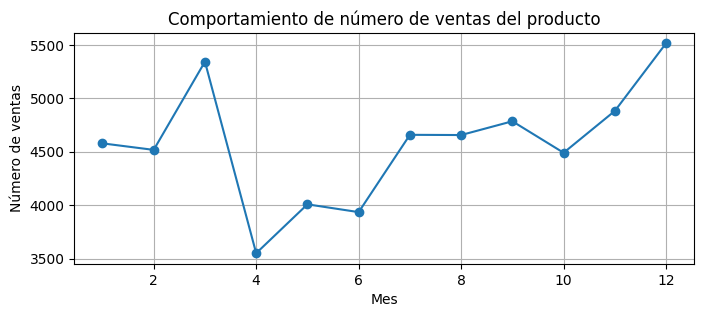

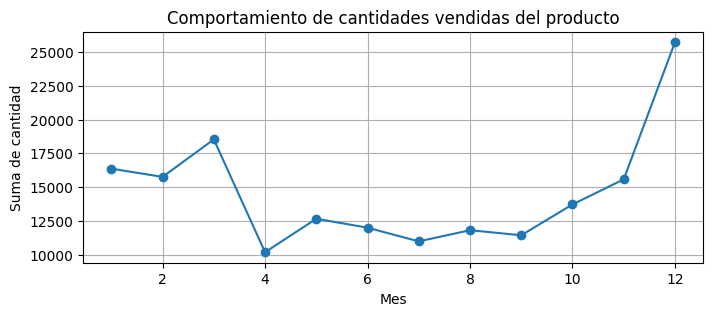

In [69]:
import matplotlib.pyplot as plt

# Filtrar por producto_general para graficar comportamiento mensual de ventas y cantidades
producto_seleccionado= "Tomate"
ventasxproducto = ventas_generales_mes[ventas_generales_mes['producto_general'] == producto_seleccionado]

# Graficar el comportamiento de 'conteo_registros' por mes
plt.figure(figsize=(8, 3))
plt.plot(ventasxproducto['month'], ventasxproducto['conteo_registros'], marker='o', linestyle='-')
plt.title('Comportamiento de número de ventas del producto')
plt.xlabel('Mes')
plt.ylabel('Número de ventas')
plt.grid(True)
plt.show()

# Graficar el comportamiento de 'suma_cantidad' por mes
plt.figure(figsize=(8, 3))
plt.plot(ventasxproducto['month'], ventasxproducto['suma_cantidad'], marker='o', linestyle='-')
plt.title('Comportamiento de cantidades vendidas del producto')
plt.xlabel('Mes')
plt.ylabel('Suma de cantidad')
plt.grid(True)
plt.show()


### Calibración de parámetros

Se realiza la calibración de parámetros modificando el valor de la desviación estándar para considerar anomalías.

A continuación, tenemos los resultados con el valor de desviación estándar 1:

<img src="SD 1.png" width="" align="" />

Además, tenemos los resultados con el valor de desviación estándar 2:

<img src="SD 2.png" width="" align="" />

Finalmente, los resultados con el valor de desviación estándar 3:

<img src="SD 3.png" width="" align="" />

Según la calibración de parámetros realizada y por la cantidad de alertas generadas, se utilizará el valor de desviación estándar de 2. Esto dado que al utilizar el valor 1 se genera alertamiento para el 56% de los productos, siendo un valor bastante alto y no sería anómalo; por su parte, el valor 3 genera alertamiento para solo el 8% de los productos, lo cual, no favorece la creación del ranking de alertamiento propuesto.

BUSCAR EN INSTRUCCIONES PUNTO DE SIGUIENTES PASOS......

Pendiente: EDA, Plan de implementación (este es general para las dos técnicas o modelos) se refiere a la integración entre los datos y el tablero de control, Siguientes pasos (por técnica), realizar informe.

# Market Basket

In [70]:
!pip install apyori
from apyori import apriori


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip



   - El **soporte**  es la probabilidad de que un artículo o conjunto de artículos aparezca en la canasta de compra. Por ejemplo:
   
       -  El soporte de X, es la probabilidad de comprar el producto X:
          
          \begin{align}
            Soporte(X) = Pr(X)
           \end{align}

       -  El soporte de X y Y, es la probabilidad conjunta de compra de X e Y:
           
           \begin{align}
            Soporte(X\&Y) = Pr(X,Y)
           \end{align}



   - La **confianza** es un indicador de la frecuencia con que la regla es cierta.  Esta dada por la probabilidad condicional, y mide la probabilidad de que el producto Y haya sido comprado dado que se compró el producto X:
    
        \begin{align}
        Confianza (X\rightarrow Y)= Pr(Y|X) = \frac{Soporte(X\&Y)}{Soporte(X)}= \frac{Pr(X\&Y)}{Pr(X)}
        \end{align}
    
    
   - El **lift** es el ratio entre la confianza observada de $X\rightarrow Y$ y el soporte de $Y$. Es un indicador que busca responder la pregunta: si un individuo compra el producto X, ¿podemos decir algo acerca de si comprará o no el producto Y con cierto nivel de confianza?. 
   
        \begin{align}
            Lift(X\rightarrow Y)= \frac{Soporte(X\&Y)}{Soporte(X)Soporte(Y)}= \frac{Pr(Y|X)}{Pr(X)Pr(Y)}
        \end{align}
    
  Su rango es  $[0,\infty]$ y nos da una medida del aumento de la probabilidad conjunta relativa a lo que esperaríamos si X y Y fuesen independientes (Recordemos que si dos eventos son independientes $ Pr(X,Y)= Pr(X)Pr(Y)$.  Entonces si, el Lift es:
  
      - Igual a 1, quiere decir que no hay correlación en la compra de los artículos.
      - Mayor a 1 quiere decir que hay es más probable que se compre el artículo Y, cuando se compró X.
      - Menor a 1, es decir que es menos probable que se compre Y, cuando se compró X.


In [71]:
try: 
    records = descargar_datos('records.pkl')
except:
    Datos_para_apriori = df[['nro_orden','producto_general']].drop_duplicates()
    records = []
    for i in Datos_para_apriori['nro_orden'].unique():
        records.append(list(Datos_para_apriori[Datos_para_apriori['nro_orden'] == i]['producto_general'].values))
    def Cargar_a_PKL(archivo,nombre):
        ruta_archivo =nombre+'.pkl'
        with open(ruta_archivo, 'wb') as f:
            pickle.dump(archivo,f)

    Cargar_a_PKL(records,'records')

Calibración de Parametros

In [72]:
soportes = [0.005,0.01,0.02]
confianzas = [0.5,0.7]
lifts = [2,4]

Parametros = {}
Cant_asociaciones = []

for supp in soportes:
    for conf in confianzas:
        for lift_valor in lifts:
            Parametros[supp,conf,lift_valor]=len(list(apriori(records, min_support=supp, min_confidence=conf, min_lift=lift_valor,max_length=3)))

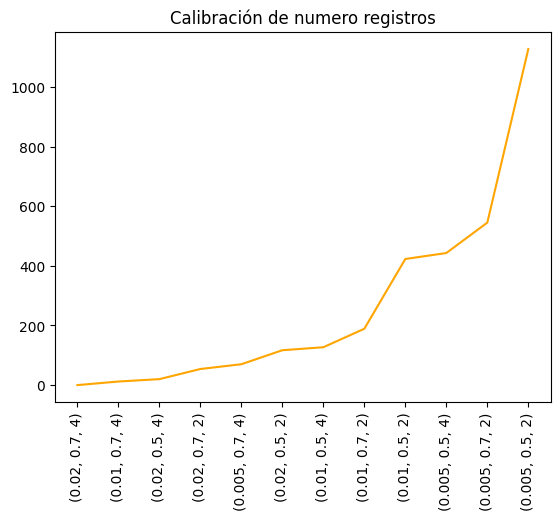

In [73]:
df_calibracion = pd.DataFrame(Parametros.values(),index=Parametros.keys(),columns=['Registros']).sort_values('Registros')
indices = df_calibracion.index.tolist()

plt.plot(df_calibracion['Registros'].values,color='orange')
plt.xticks(ticks=range(len(df_calibracion.index)), labels=df_calibracion.index, rotation=90)
plt.title('Calibración de numero registros')
plt.show()
#df_calibracion['Registros'].values

Reglas de asociación

In [74]:
association_rules = apriori(records, min_support=0.01, min_confidence=0.5, min_lift=4,max_length=3)
association_results = list(association_rules)
association_results

print("Derivamos {} reglas de asociación.".format(len(association_results)))

Derivamos 127 reglas de asociación.


In [75]:
print(association_results[0])

RelationRecord(items=frozenset({'Mazorca', 'Apio'}), support=0.015838115030250587, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Mazorca'}), items_add=frozenset({'Apio'}), confidence=0.5016850146034598, lift=4.15118660273063)])


En este caso las Zanahorias se compran a menudo con Habichuelas:
 - El valor de soporte es 0.02, que nos dice que el 2% de los ordenes compraron Zanahorias.
 -  El nivel de confianza es .62 nos dice que la probabilidad de que los usuarios Compren Zanahorias dado que compraron Habichuelas  es del  62%.
 - Finalmente, el lift de 4.21 nos dice que la probabilidad de que alguien compre Zanahorias dado que compro Habichuelas es 4.2 veces más altas a la probabilidad de comprarlos de manera independiente

### Para ver ver reglas de asociación usamos la función reglas

In [76]:
def ver_reglas(num):
    #Primer índice de la lista interna:
    #Contiene elemento base y el adicional
    item = association_results[num]
    pair = item[0] 
    items = [x for x in pair]
    try:
        print("Regla: " + items[0] + " -> " + items[1]+ ',' + items[2])
    except:
        print("Regla: " + items[0] + " -> " + items[1])
    #Segundo índice de la lista interna
    print("Soporte: " + str(item[1]))

    #Tercer índice de la lista ubicada en 0th
    #del tercer índice de la lista interna

    print("Confianza: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")
ver_reglas(120)

Regla: Zanahoria -> Pepino,Platano
Soporte: 0.011192362524735973
Confianza: 0.6828212894850715
Lift: 4.622601113185957


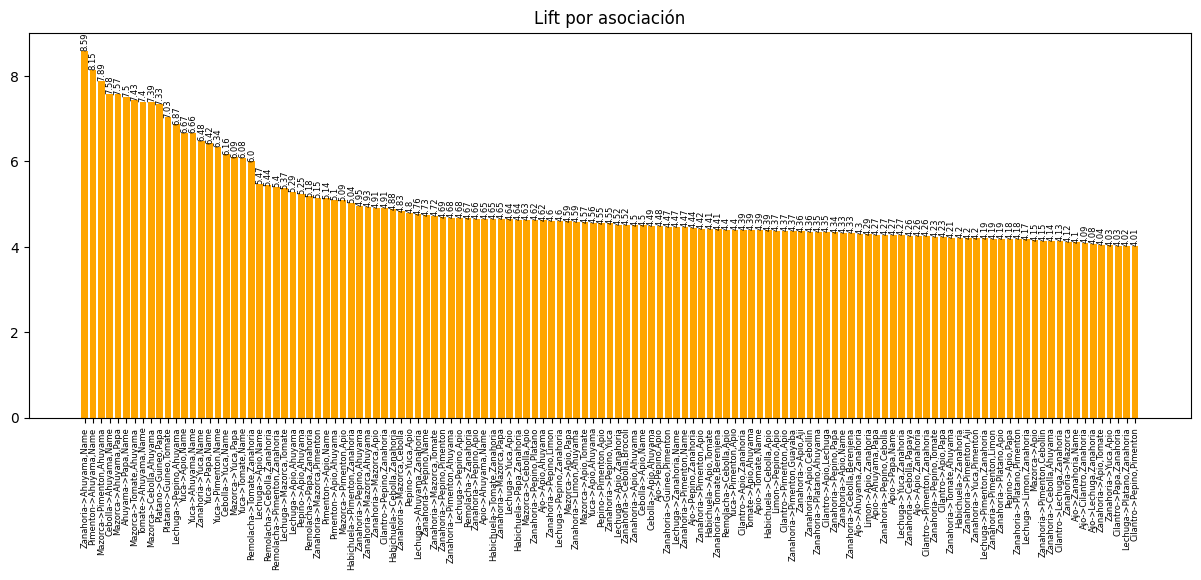

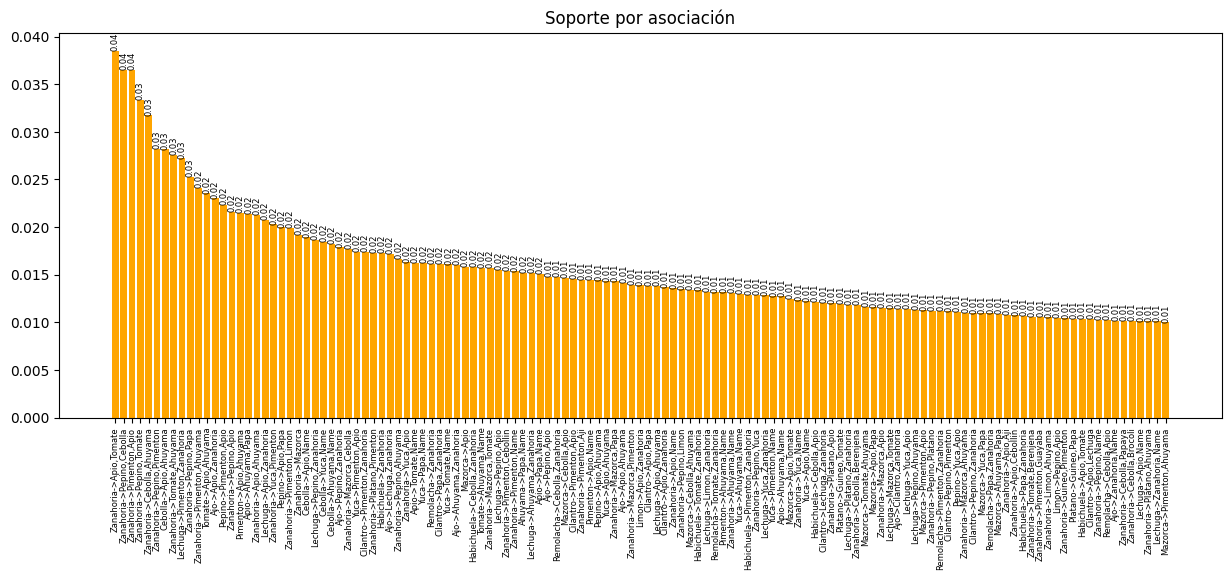

In [77]:
def Obtener_Metrica(num):
    item = association_results[num]
    pair = item[0] 
    items = [x for x in pair]
    
    #Productos_nombre,Soporte,Confianza,Lift
    try:
        regla = items[0]+'->'+items[1]+','+items[2]
    except:
        regla = items[0]+'->'+items[1]

    return (regla,item[1],item[2][0][2],item[2][0][3])

Lista_para_df=[]
for registro in np.arange(0,len(association_results)):
    Lista_para_df.append(Obtener_Metrica(registro))

df_Reglas_asociación = pd.DataFrame(Lista_para_df,columns=['Regla','Soporte','Confianza','Lift'])

def dibujar(df,columna):
    df = df.sort_values(columna,ascending=False)
    plt.figure(figsize=(15,5))
    plt.bar(x=df['Regla'],height=df[columna],color='orange')
    plt.title(columna + ' por asociación')
    plt.xticks(rotation=90,fontsize=6)
    for num,item in enumerate(df[columna]):
        plt.text(x=num,y=item,s=np.round(item,2),rotation=90,fontsize=6,va='bottom',ha='center')
    plt.show()

dibujar(df_Reglas_asociación,'Lift')
dibujar(df_Reglas_asociación,'Soporte')

In [78]:
df_Reglas_asociación.to_csv('Reglas_Asociación.csv')
df_alertamiento.to_csv('df_alertamiento.csv')

In [79]:
df_Reglas_asociación.dtypes

Regla         object
Soporte      float64
Confianza    float64
Lift         float64
dtype: object

In [80]:
df_Reglas_asociación.shape

(127, 4)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=33f885fa-e5b6-4249-a1f0-66b107de2818' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>